In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model, Model
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, Image
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split

print("TensorFlow Version:", tf.__version__)
drive.mount('/content/drive')

TensorFlow Version: 2.18.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
GDRIVE_PROJECT_PATH = Path('/content/drive/MyDrive/pap_project/data/raw/')
MODELS_PATH = Path('/content/drive/MyDrive/pap_project/final_models/')

IMG_SIZE = (224, 224)
CLASS_NAMES = ['Normal', 'Abnormal']
LABEL_MAP = {'normal': 0, 'abnormal': 1}
SEED = 42

if not MODELS_PATH.exists():
    print(f"ERROR: Model directory not found: {MODELS_PATH}")
else:
    print(f"Model directory found: {MODELS_PATH}")

Model directory found: /content/drive/MyDrive/pap_project/final_models


In [5]:
def find_image_paths_by_type(data_path, label_map):
    image_paths, labels = [], []
    for ext in ['*.bmp', '*.BMP']:
        for file in data_path.rglob(ext):
            parent_folder = file.parent.name.lower()
            if 'carcinoma' in parent_folder or 'dysplastic' in parent_folder:
                labels.append('abnormal')
                image_paths.append(str(file))
            elif 'normal' in parent_folder:
                labels.append('normal')
                image_paths.append(str(file))
    df = pd.DataFrame({'filepath': image_paths, 'label': labels})
    df['label_id'] = df['label'].map(label_map).astype(int)
    return df

def load_test_data():
    sipakmed_paths = glob.glob(str(GDRIVE_PROJECT_PATH / 'im_*' / '*' / 'CROPPED' / '*.bmp'))
    sipakmed_labels = ['normal' if 'im_Parabasal' in p or 'im_Superficial-Intermediate' in p else 'abnormal' for p in sipakmed_paths]
    sipakmed_full_df = pd.DataFrame({'filepath': sipakmed_paths, 'label': sipakmed_labels})
    sipakmed_full_df['label_id'] = sipakmed_full_df['label'].map(LABEL_MAP).astype(int)
    _, sipakmed_df = train_test_split(sipakmed_full_df, test_size=0.15, random_state=SEED, stratify=sipakmed_full_df['label_id'])
    print(f"Loaded {len(sipakmed_df)} Sipakmed test images.")
    return sipakmed_df

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

sipakmed_test_df = load_test_data()
print("\nTest dataframes are ready.")

Loaded 608 Sipakmed test images.

Test dataframes are ready.


In [6]:
# ─────────── LOAD MODEL & DIAGNOSE CONV CHAIN ───────────
from pathlib import Path
import tensorflow as tf
from collections import OrderedDict, deque

MODEL_FILE = MODELS_PATH / "VGG16_Color_best.keras"    # ←-- adjust filename

tf.keras.backend.clear_session()
model = tf.keras.models.load_model(MODEL_FILE, compile=False)
print("Model loaded (total params:", model.count_params(), ")")

# quick summary (first & last 5 layers)
model.summary(line_length=120, positions=[.45, .65, .8, 1.0], expand_nested=False)

# walk backwards from model.output to collect conv layers
def conv_chain(m):
    chain = OrderedDict()
    q = deque([m.output])
    seen = set()
    while q:
        t = q.popleft()
        if t in seen or t is None: continue
        seen.add(t)
        layer = t._keras_history[0]
        if isinstance(layer, (tf.keras.layers.Conv2D,
                              tf.keras.layers.SeparableConv2D)):
            chain[layer.name] = t.shape
        for node in layer._inbound_nodes:
            q.extend(node.input_tensors)
    return chain

chain = conv_chain(model)
print(f"\n{len(chain)} convolution layers feed the classifier:")
for k, shp in chain.items():
    print(f" • {k:<25}  {shp}")

Model loaded (total params: 14977857 )


Model: "VGG16_Color"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                                   ┃ Output Shape                 ┃              Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━
│ input_layer_14 (InputLayer)                                    │ (None, 224, 224, 3)          │                  
├────────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────
│ vgg16 (Functional)                                             │ (None, 7, 7, 512)            │           14,714,
├────────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────
│ global_average_pooling2d_6 (GlobalAveragePooling2D)            │ (None, 512)                  │                  
├────────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────
│ dropout_8 (Dropout)                                            │ (None, 512)                  │                  
├────────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────
│ dense_14 (Dense)                                               │ (None, 512)                  │              262,
├────────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────
│ dense_15 (Dense)                                               │ (None, 1)                    │                  
└────────────────────────────────────────────────────────────────┴──────────────────────────────┴──────────────────

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


0 convolution layers feed the classifier:


Model loaded: InceptionResNetV2_Color_best_finetuned.keras


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_19']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


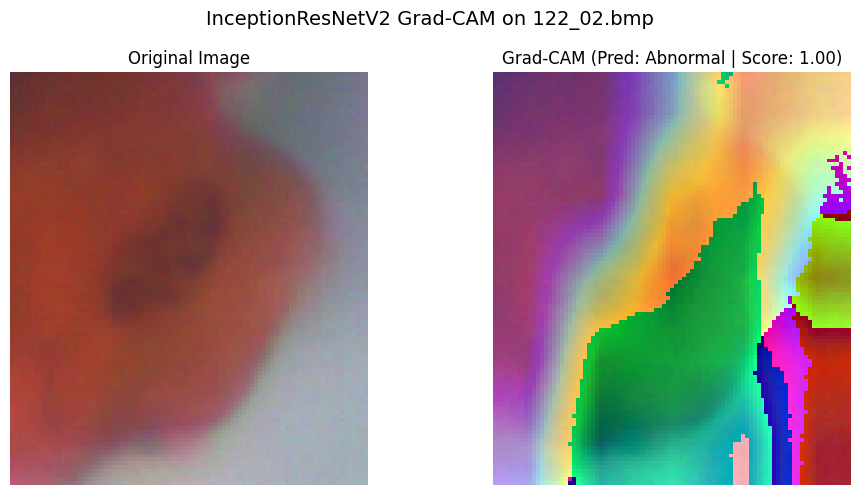

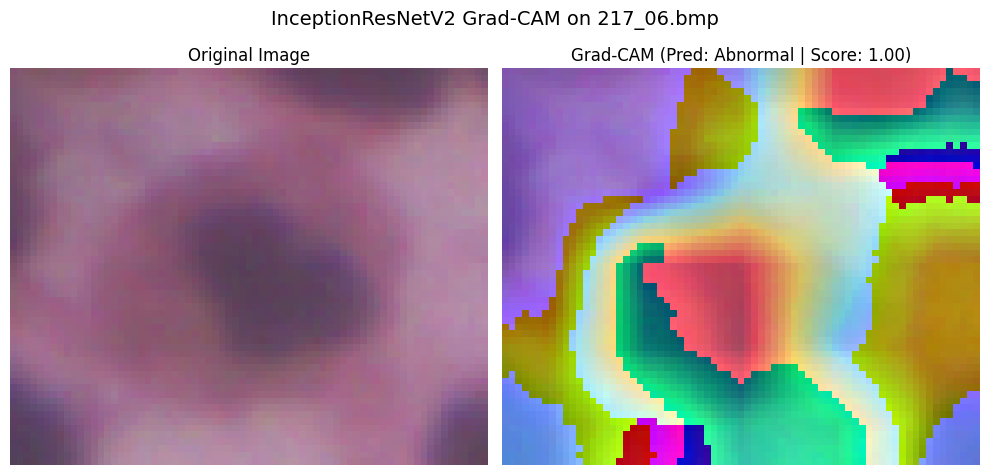

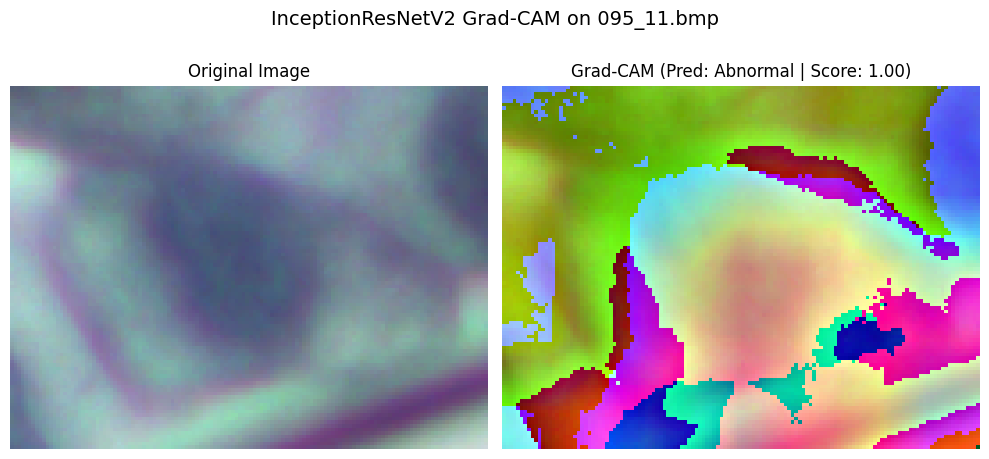

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# Import the correct application module
from tensorflow.keras.applications import inception_resnet_v2 ### <<< CHANGE HERE
from pathlib import Path

tf.keras.backend.clear_session()

# Load the InceptionResNetV2 fine-tuned model
MODEL_FILE = MODELS_PATH / "InceptionResNetV2_Color_best_finetuned.keras"
if not MODEL_FILE.exists():
    # Fallback if the fine-tuned model isn't found
    MODEL_FILE = MODELS_PATH / "InceptionResNetV2_Color_best.keras"

model = tf.keras.models.load_model(MODEL_FILE, compile=False)
print("Model loaded:", MODEL_FILE.name)
# model.summary()


BACKBONE_NAME = "inception_resnet_v2"
LAST_CONV_LAYER_NAME = "conv_7b"

# Get the backbone model itself
backbone = model.get_layer(BACKBONE_NAME)

# Find the output of the last convolutional layer WITHIN the backbone
last_conv_output = backbone.get_layer(LAST_CONV_LAYER_NAME).output

# Find the output of the ENTIRE backbone
backbone_output = backbone.output

# Reconstruct the head of the model (layers after the backbone)
head_layers = []
found_backbone = False
for layer in model.layers:
    if layer.name == BACKBONE_NAME:
        found_backbone = True
        continue
    if found_backbone:
        head_layers.append(layer)

# Apply each subsequent layer to the backbone's output
x = backbone_output
for layer in head_layers:
    x = layer(x)
final_prediction = x

# Create the grad_model starting from the backbone's input
grad_model = tf.keras.Model(
    inputs=backbone.inputs,
    outputs=[last_conv_output, final_prediction]
)
grad_model.trainable = False

@tf.function
def grad_cam(img_batch):
    """Return a heatmap for each image in the batch."""
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_batch, training=False)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.einsum("bhwc,bc->bhw", conv_outputs, pooled_grads)
    cam = tf.nn.relu(cam)
    max_val = tf.reduce_max(cam, axis=(1, 2), keepdims=True)
    cam = cam / (max_val + 1e-8)
    return cam

def overlay_heatmap(img_path, heatmap, alpha=0.5):
    """Overlays a heatmap onto an image."""
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)
    heatmap_resized = tf.image.resize(np.expand_dims(heatmap, -1), img.shape[:2]).numpy()
    heatmap_jet = np.uint8(255 * heatmap_resized.squeeze())
    jet_colors = mpl.colormaps["jet"](np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_jet]
    jet_heatmap_img = tf.keras.utils.img_to_array(
        tf.keras.utils.array_to_img(jet_heatmap)
    )
    overlaid_img = jet_heatmap_img * alpha + img
    return np.uint8(overlaid_img)


PREPROC = inception_resnet_v2.preprocess_input
IMG_SIZE = (224, 224)

sample_df = sipakmed_test_df[sipakmed_test_df['label'] == 'abnormal'].sample(3, random_state=42)

for _, row in sample_df.iterrows():
    path = Path(row["filepath"])
    raw_img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    raw_img_array = tf.keras.utils.img_to_array(raw_img)
    proc_img = PREPROC(np.expand_dims(raw_img_array.copy(), axis=0))

    pred_score = model(proc_img, training=False).numpy()[0, 0]
    pred_class = CLASS_NAMES[int(pred_score > 0.5)]

    heatmap = grad_cam(proc_img).numpy()[0]

    overlay = overlay_heatmap(path, heatmap)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.utils.load_img(path))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM (Pred: {pred_class} | Score: {pred_score:.2f})")
    plt.axis("off")

    plt.suptitle(f"InceptionResNetV2 Grad-CAM on {path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()